(Copied from auto_trigger)

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from pynq import allocate

In [2]:
from pynq import PL
PL.reset()
import xrfdc

In [3]:
from pynq import Overlay
ol = Overlay('./doppler_sweeper.bit')

In [4]:
# sanity check that we are at 150 MHz
from pynq import Clocks
print(Clocks.fclk0_mhz)
Clocks.fclk0_mhz = 150
print(Clocks.fclk0_mhz)

214.283571
149.9985


In [5]:
rf = ol.usp_rf_data_converter_0
adc_tile = rf.adc_tiles[2]
adc_block = adc_tile.blocks[0]
adc_block.Dither = 0 #doesn't really matter for this lab, but let's turn off.
center_frequency = 1575.43
doppler = 0
adc_block.MixerSettings['Freq']= center_frequency + doppler / 1e6 # set the frequency of the Numerically controlled oscillator.
adc_block.UpdateEvent(xrfdc.EVENT_MIXER) #every time setting is changed, must call this.
print(adc_block.MixerSettings)

{'Freq': 1575.429999999993, 'PhaseOffset': 0.0, 'EventSource': 2, 'CoarseMixFreq': 0, 'MixerMode': 3, 'FineMixerScale': 0, 'MixerType': 2}


In [6]:
N = 4096
num_width = 32

In [8]:
mmio_interface = ol.mmio_interface
dma_out_argmax = ol.axi_dma_0
dma_prn_config = ol.axi_prn_config
dma_iq_config = ol.axi_iq_config
dma_ifft_config = ol.axi_ifft_config

In [9]:
# set up ffts
fft_config = allocate(1, dtype=np.uint8)
fft_config[0] = 0
ifft_config = allocate(1, dtype=np.uint8)
ifft_config[0] = 1
# note they are default inverse (1)
dma_prn_config.sendchannel.transfer(fft_config)
dma_prn_config.sendchannel.wait()
dma_iq_config.sendchannel.transfer(fft_config)
dma_iq_config.sendchannel.wait()
dma_ifft_config.sendchannel.transfer(ifft_config)
dma_ifft_config.sendchannel.wait()

In [10]:
# numerical helpers
def get_twos_from_decimal(decimal, num_bits):
    decimal = int(decimal)
    return decimal % (1<<num_bits)

def get_value_from_complex(real, imag, num_bits):
    return get_twos_from_decimal(real, num_bits)*(1<<num_bits)+get_twos_from_decimal(imag, num_bits)

def get_decimal_from_twos(twos, num_bits):
    twos = int(twos)
    if twos >= (1<<(num_bits-1)):
        return twos - (1<<num_bits)
    else:
        return twos
    
def get_components(complex_array, num_bits):
    return {
        'real': np.array([get_decimal_from_twos(x // (1<<num_bits), num_bits) for x in complex_array]),
        'imag': np.array([get_decimal_from_twos(x % (1<<num_bits), num_bits) for x in complex_array])
    }

In [11]:
res_data = allocate(2*N, dtype=np.uint32)
def get_conv_data(): #outputs 1 code block
    #mmio_interface.write(0x08, 0)
    #time.sleep(0.001)
    mmio_interface.write(0x08, 1)
    dma_out_conv.recvchannel.transfer(res_data)
    dma_out_conv.recvchannel.wait()
    return res_data

In [12]:
def doppler_sweep(prn_id, start = -8000, end = 8000, step = 100, scaling = 16): #sweeps frequency range
    doppler_range = list(range(start, end, step))
    mmio_interface.write(0x00, scaling)
    mmio_interface.write(0x04, prn_id-1)

    amplitudes = []
    for doppler in doppler_range:
        
#         if doppler % 1000 == 0: print(f'on doppler {doppler}')
            
        # set adc frequency now
        adc_block.MixerSettings['Freq']= center_frequency + doppler / 1e6 # set the frequency of the Numerically controlled oscillator.
        adc_block.UpdateEvent(xrfdc.EVENT_MIXER) #every time setting is changed, must call this.
        
        res_data = get_conv_data()

        # now do calculation
        real = res_data[1::2]
        imag = res_data[0::2]
        real_decimal = [get_decimal_from_twos(x, num_width) for x in real]
        imag_decimal = [get_decimal_from_twos(x, num_width) for x in imag]
        convolve = np.array([x+y*1j for (x,y) in zip(real_decimal, imag_decimal)])
        peak_position = np.argmax(abs(convolve))
        amplitudes.append(abs(convolve)[peak_position]**2)

    plt.plot(doppler_range, amplitudes)
    best_doppler = np.argmax(amplitudes)
    return amplitudes

In [13]:
def prn_sweep(start = -5000, end = 5000, step = 100, scaling = 16): #sweeps all 37 prns
    full_data = []
    for i in range(1,38):
        amplitudes = doppler_sweep(i,start=start, end=end, step=step, scaling=scaling)
        full_data.append(amplitudes)
        print(f"Frequency sweep of prn ID {i}, max {max(amplitudes)}")        
    return full_data

In [14]:
def test_shift(doppler_shift, prn_id):
    mmio_interface.write(0x04, prn_id-1)
    
    #doppler_shift = 2200
    adc_block.MixerSettings['Freq']= center_frequency + doppler_shift / 1e6 # set the frequency of the Numerically controlled oscillator.
    adc_block.UpdateEvent(xrfdc.EVENT_MIXER) #every time setting is changed, must call this.
    
    argmax_data = allocate(2*1000, np.int32)
    dma_out_argmax.recvchannel.transfer(argmax_data)
    for i in range(1000):
        #print(f"on sample {i}")
        get_conv_data()
        dma_out_conv.sendchannel.transfer(res_data)
        dma_out_conv.sendchannel.wait()
    #     print(res_data)
    # ok, 1000 are done, we expect an output at dma_out_argmax
    dma_out_argmax.recvchannel.wait()
    
    indices = argmax_data[0::2]
    values = argmax_data[1::2]
    real = get_components(values,16)["real"]
    imag = get_components(values,16)["imag"]
    mag = [abs(real[i]+imag[i]*1j) for i in range(1000)]
    
    #plt.plot(list(range(0,50)), imag[:50])
    #plt.plot(list(range(0,50)), real[:50])
    
    return(sum(mag))

In [15]:
def collect(doppler_shift, prn_id):
    mmio_interface.write(0x04, prn_id-1)
    
    adc_block.MixerSettings['Freq']= center_frequency + doppler_shift / 1e6 # set the frequency of the Numerically controlled oscillator.
    adc_block.UpdateEvent(xrfdc.EVENT_MIXER) #every time setting is changed, must call this.
    
    argmax_data = allocate(2*1000, np.int32)
    dma_out_argmax.recvchannel.transfer(argmax_data)
    for i in range(1000):
        #print(f"on sample {i}")
        get_conv_data()
        dma_out_conv.sendchannel.transfer(res_data)
        dma_out_conv.sendchannel.wait()
    #     print(res_data)
    # ok, 1000 are done, we expect an output at dma_out_argmax
    dma_out_argmax.recvchannel.wait()
    
    indices = argmax_data[0::2]
    values = argmax_data[1::2]
    real = get_components(values,16)["real"]
    imag = get_components(values,16)["imag"]
    mag = [abs(real[i]+imag[i]*1j) for i in range(1000)]
    
    #plt.plot(list(range(0,50)), imag[:50])
    #plt.plot(list(range(0,50)), real[:50])
    
    return(real, imag, indices)

In [16]:
# set scaling
mmio_interface.write(0x00, 16)

# set prn
mmio_interface.write(0x04, 26)

# set center_frequency
doppler_shift = 2000
adc_block.MixerSettings['Freq']= center_frequency + doppler / 1e6 # set the frequency of the Numerically controlled oscillator.
adc_block.UpdateEvent(xrfdc.EVENT_MIXER) #every time setting is changed, must call this.



In [17]:
argmax_data = allocate(2*1000, np.int32)

In [18]:
dma_out_argmax.recvchannel.transfer(argmax_data)
dma_out_argmax.recvchannel.wait()

KeyboardInterrupt: 

In [255]:
indices = argmax_data[0::2]
values = argmax_data[1::2]
real = get_components(values,16)["real"]
imag = get_components(values,16)["imag"]
mag = [abs(real[i]+imag[i]*1j) for i in range(1000)]


In [256]:
sum(mag)

5332882.576923648

(array([ 79., 179., 121.,  64.,  36.,  40.,  75., 134., 179.,  93.]),
 array([-6134. , -4916.6, -3699.2, -2481.8, -1264.4,   -47. ,  1170.4,
         2387.8,  3605.2,  4822.6,  6040. ]),
 <BarContainer object of 10 artists>)

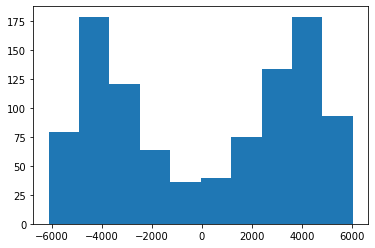

In [257]:
plt.hist(imag)

(array([ 32., 177., 150.,  80.,  43.,  55.,  76., 166., 194.,  27.]),
 array([-6568. , -5246.6, -3925.2, -2603.8, -1282.4,    39. ,  1360.4,
         2681.8,  4003.2,  5324.6,  6646. ]),
 <BarContainer object of 10 artists>)

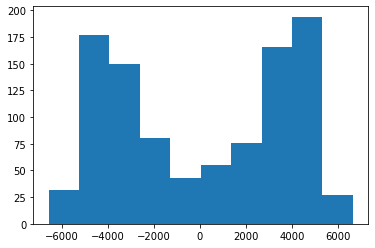

In [258]:
plt.hist(real)

(array([  1.,   0.,   0.,   0.,   0.,   0.,  41., 674., 265.,  19.]),
 array([   0.        ,  687.2317222 , 1374.4634444 , 2061.6951666 ,
        2748.92688881, 3436.15861101, 4123.39033321, 4810.62205541,
        5497.85377761, 6185.08549981, 6872.31722201]),
 <BarContainer object of 10 artists>)

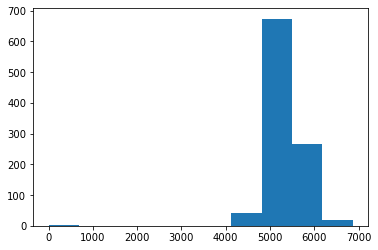

In [259]:
plt.hist(mag)

(array([105.,  87.,  98.,  78.,  72., 189.,  89., 106.,  80.,  96.]),
 PynqBuffer([   0. ,  408.6,  817.2, 1225.8, 1634.4, 2043. , 2451.6,
             2860.2, 3268.8, 3677.4, 4086. ]),
 <BarContainer object of 10 artists>)

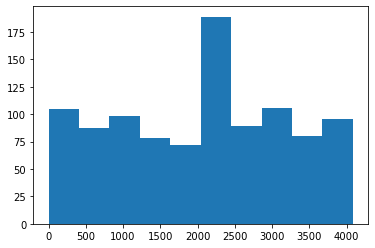

In [260]:
plt.hist(indices)

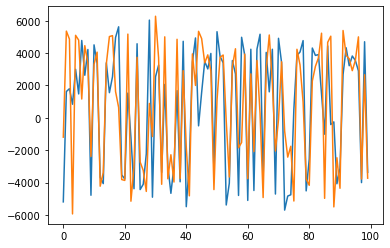

In [261]:
plt.plot(list(range(0,100)), imag[:100])
plt.plot(list(range(0,100)), real[:100])

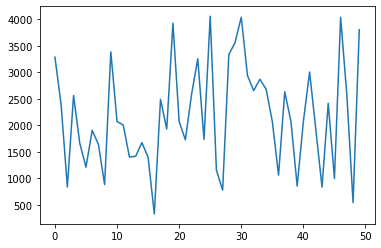

In [262]:
plt.plot(list(range(0,50)), indices[200:250])

In [267]:
for shift in range(-750,-550,10):
    print(shift, test_shift(shift, 27))

-750 6436682.984585212
-740 6381687.652548128
-730 6417685.390742578
-720 6444875.079044647
-710 6478967.700345809
-700 6507617.830121768
-690 6466161.840673993
-680 6396443.707819354
-670 6488743.442112497
-660 6530339.801534394
-650 6475220.437923196
-640 6351481.263008285
-630 6592195.3753450615
-620 6328565.366353539
-610 6370768.3643006915
-600 6402572.502537211
-590 6498647.975831842
-580 6555223.3881138945
-570 6616937.046270868
-560 6486779.22232295


In [472]:
real, imag, indices = collect(-1680,27)
phase_shift = np.array([np.angle(real[i]+imag[i]*1j) for i in range(1000)])

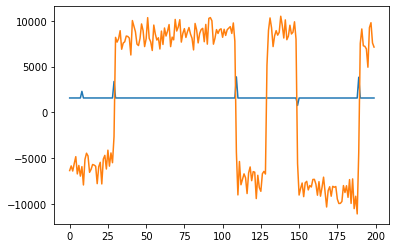

In [473]:
base_index = 400
number = 200
plt.plot(list(range(0,number)), indices[base_index:base_index+number])
plt.plot(list(range(0,number)), real[base_index:base_index+number])

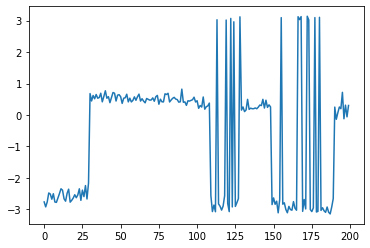

In [474]:
plt.plot(list(range(0,number)), phase_shift[base_index:base_index+number])

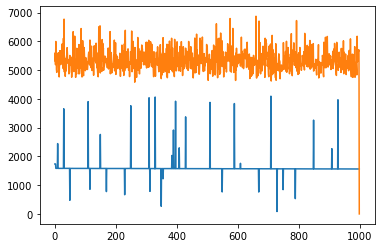

In [475]:
plt.plot(list(range(0,1000)), indices)
plt.plot(list(range(0,1000)), mag)

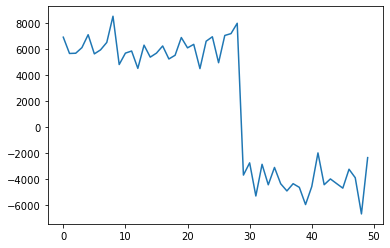

In [476]:
plt.plot(list(range(0,50)), real[200:250])

In [477]:
import statistics
def bpsk_filter(phase_shift, indices, downsample = 5):
    #only take data that is close to the index
    #we down sample by 5? for now
    filtered = []
    for i in range(0,1000,downsample):
        subphase = list(phase_shift[i:min(1000,i+downsample)])
        subindices = list(indices[i:min(1000,i+downsample)])
        indexmode = statistics.mode(subindices)
        location = subindices.index(indexmode)
        chosenphase = subphase[location]
        filtered.append(chosenphase)
        print(i,indexmode,chosenphase)
    return(filtered)
    
filtered = bpsk_filter(phase_shift, indices)

0 1738 2.647378101152316
5 1584 0.1827103171811606
10 1583 -3.028509411473188
15 1583 -2.985947610945101
20 1583 -2.8821127478721493
25 1583 -2.8353268757973322
30 1584 0.4801344594866432
35 1584 0.2971953569537352
40 1584 0.1486284413393077
45 1584 0.24950860808544598
50 1583 -2.905936634461994
55 1583 -2.742225389048536
60 1582 -2.9350197590257205
65 1582 -2.681559151733537
70 1582 -2.4833058853774803
75 1582 -2.5349616773067742
80 1582 -2.5904331243302736
85 1582 -2.5647900648656305
90 1582 -2.3261916802887312
95 1582 -2.6030938079546475
100 1582 -2.5374226454548534
105 1582 -2.44084445418038
110 1581 0.3008007531748553
115 1581 0.37184482324561974
120 1581 0.5101422245249408
125 1581 0.6451931545558228
130 1581 0.5527484146099132
135 1581 0.8648914729859354
140 1579 0.9302631020836563
145 1581 0.6129252427105056
150 1580 -2.267469837642233
155 1581 -2.2791597111691777
160 1580 -2.325689927241129
165 1580 -2.117437618362971
170 1579 0.9364115215341667
175 1579 1.2206053362458877
180

In [478]:
#testing how fast the code delay shifts
#print(statistics.mode(indices[0:10]))
#print(statistics.mode(indices[10:20]))
#print(statistics.mode(indices[90:95]))
#print(statistics.mode(indices[910:915]))

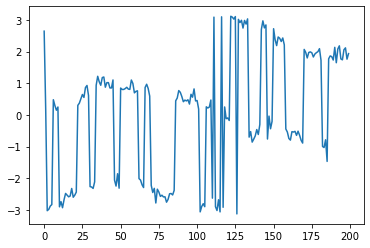

In [486]:
plt.plot(list(range(0,200)), filtered)
plt.savefig('bpsk-2.png')

In [494]:
with open("filtered-data", "w") as z:
    for i in filtered:
        z.write(str(i))
        z.write("\n")

In [485]:
np.pi % (2* np.pi)

3.141592653589793